In [1]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.15"

import sys
sys.path.append('..')

from disk_model.objective_functions import jax_model, objective_model, objective_fit, log_likelihood, Parameter_Index
from disk_model.SLD_utils import DoubleHenyeyGreenstein_SPF, InterpolatedUnivariateSpline_SPF, EMP_PSF, DustEllipticalDistribution2PowerLaws, Winnie_PSF
from disk_model.SLD_ojax import ScatteredLightDisk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)

/home/mihirkondapalli/anaconda3/envs/jwst_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
Could not import CuPy. Setting: use_gpu=False (i.e., using CPU operations).


## Plotting Disks

In [2]:
#Now, plotting disks is made simpler through the new objective function. You need to define four dictionaries, disk_params, spf_params, psf_params, and
#misc_params.

'''
disk_params: (Always use ScatteredLightDisk) (Template for disk_params in objective_functions.py)
    ScatteredLightDisk:
        'accuracy', 'alpha_in', 'alpha_out', 'sma', 'e', 'ksi0', 'gamma', 'beta', 'amin', 'dens_at_r0', 'inclination', 'position_angle', 'x_center',
        'y_center', 'halfNbSlices', 'omega'

spf_params: (Template for spf_params in params field of respective class)
    HenyeyGreenstein_SPF:
        'g'
    DoubleHenyeyGreenstein_SPF:
        'g1', 'g2', 'weight'
    InterpolatedUnivariateSpline_SPF:
        'low_bound', 'up_bound', 'num_knots', 'knot_values'

psf_params: (Template for psf_params in params field of respective class)
    GAUSSIAN_PSF:
        'FWHM', 'xo', 'yo', 'theta', 'offset', 'amplitude'
    EMP_PSF:
        'scale_factor', 'offset'
    WINNIE_PSF:
        winnie_class instance (acts differently from rest because it works differently)

misc_params: (Not tied to any class) (Template for misc_params in objective_functions.py)
    'distance', 'pxInArcsec', 'nx', 'ny', 'flux_scaling'
''' 

"\ndisk_params: (Always use ScatteredLightDisk) (Template for disk_params in objective_functions.py)\n    ScatteredLightDisk:\n        'accuracy', 'alpha_in', 'alpha_out', 'sma', 'e', 'ksi0', 'gamma', 'beta', 'amin', 'dens_at_r0', 'inclination', 'position_angle', 'x_center',\n        'y_center', 'halfNbSlices', 'omega'\n\nspf_params: (Template for spf_params in params field of respective class)\n    HenyeyGreenstein_SPF:\n        'g'\n    DoubleHenyeyGreenstein_SPF:\n        'g1', 'g2', 'weight'\n    InterpolatedUnivariateSpline_SPF:\n        'low_bound', 'up_bound', 'num_knots', 'knot_values'\n\npsf_params: (Template for psf_params in params field of respective class)\n    GAUSSIAN_PSF:\n        'FWHM', 'xo', 'yo', 'theta', 'offset', 'amplitude'\n    EMP_PSF:\n        'scale_factor', 'offset'\n    WINNIE_PSF:\n        winnie_class instance (acts differently from rest because it works differently)\n\nmisc_params: (Not tied to any class) (Template for misc_params in objective_functions.

### Normal Disk

In [3]:
spf_params = DoubleHenyeyGreenstein_SPF.params
psf_params = EMP_PSF.params

disk_params = Parameter_Index.disk_params
disk_params['sma'] = 40
disk_params['inclination'] = 60
disk_params['position_angle'] = 30

img = objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, EMP_PSF)

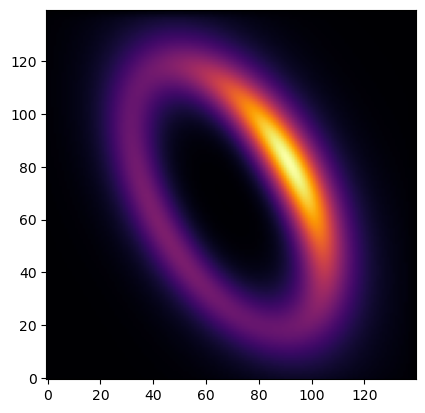

In [4]:
plt.imshow(img, origin='lower', cmap='inferno')

In [5]:
%timeit objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params, ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, EMP_PSF)

5.81 ms ± 25 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### JWST NIRCam Disk

In [6]:
#############################################
######### Read in NIRCam model PSFs #########
#############################################

x1 = 0
x2 = 4096
y1 = 0
y2 = 4096

##################### F300M #################
psf_dir = "../PSFs/F300M/"
psf_suffixes = "_F300M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = jnp.load(psf_dir+"im_mask_rolls"+psf_suffixes)
psf_inds_rolls = jnp.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_offsets = jnp.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = jnp.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = jnp.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

nircam_psf_list_f300m = [psfs,psf_inds_rolls,im_mask_rolls,unique_inds]

psf_dir = "../PSFs/F360M/"
psf_suffixes = "_F360M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = jnp.load(psf_dir+"im_mask_rolls"+psf_suffixes)
psf_inds_rolls = jnp.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_offsets = jnp.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = jnp.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = jnp.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

test_parangs = jnp.unique(np.linspace(-45, 45, 8))

In [7]:
spf_params = InterpolatedUnivariateSpline_SPF.params
psf_params = Winnie_PSF.init(psfs, psf_inds_rolls, im_mask_rolls, psf_offsets, test_parangs, 46)

spf_params['knot_values'] = jnp.array([0.3, 0.5, 0.1, 0.6, 0.9, 0.3])

disk_params = Parameter_Index.disk_params
disk_params['sma'] = 40
disk_params['inclination'] = 60
disk_params['position_angle'] = 30

img = objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, Winnie_PSF)

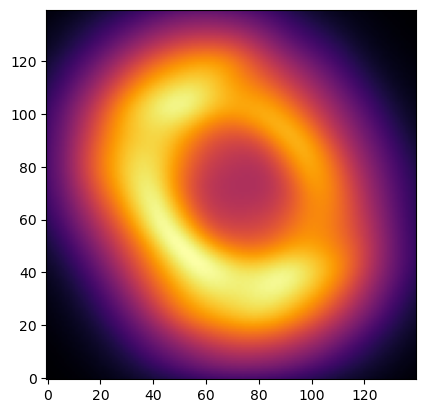

In [8]:
plt.imshow(img, origin='lower', cmap='inferno')

In [9]:
%timeit objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params, ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, Winnie_PSF)

69.4 ms ± 7.8 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Fitting Disks

#### Making Target Disk

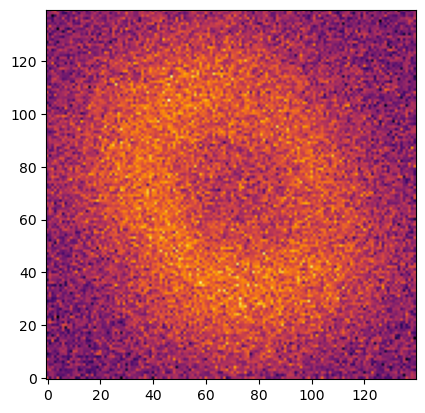

In [10]:
noise_level = 250
noise = np.random.normal(0, noise_level, img.shape)
target_image = img + noise
err_map = jnp.ones(img.shape)*noise_level
plt.imshow(target_image, origin='lower', cmap='inferno')

#### Getting Log-Likelihood

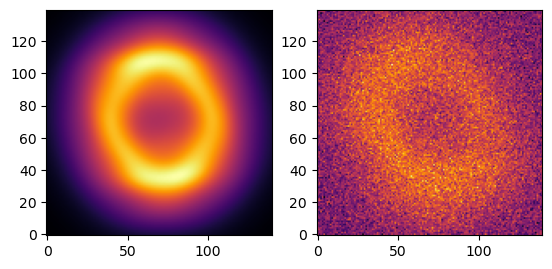

Log-Likelihood: -157070.12635858447


In [11]:
start_spf_params = InterpolatedUnivariateSpline_SPF.params.copy()
start_psf_params = Winnie_PSF.init(psfs, psf_inds_rolls, im_mask_rolls, psf_offsets, test_parangs, 46)

start_disk_params = Parameter_Index.disk_params.copy()
start_disk_params['sma'] = 30
start_disk_params['inclination'] = 45
start_disk_params['position_angle'] = 10
start_spf_params['knot_values'] = jnp.ones(6)

start_image = objective_model(start_disk_params, start_spf_params, start_psf_params, Parameter_Index.misc_params, ScatteredLightDisk,
                              DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, Winnie_PSF)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(start_image, origin='lower', cmap='inferno')
axes[1].imshow(target_image, origin='lower', cmap='inferno')
plt.show()

print(f'Log-Likelihood: {log_likelihood(start_image, target_image, err_map)}')

### Fitting Disk

In [12]:
from scipy.optimize import minimize
jax.config.update("jax_debug_nans", True)

In [14]:
# will be fitting for sma, inclination, position angle, and knot values

fit_keys = ['sma', 'inclination', 'position_angle', 'knot_values']

llp = lambda x: -objective_fit([x[0], x[1], x[2], x[3:]], fit_keys, disk_params, spf_params, psf_params, None, Parameter_Index.misc_params,
                              ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, Winnie_PSF, None, target_image,
                              err_map)

init_x = jnp.concatenate([jnp.array([start_disk_params['sma'], start_disk_params['inclination'], start_disk_params['position_angle']]), 0.5*jnp.ones(6)])

soln = minimize(llp, init_x, options={'disp': True, 'max_itr': 500})

         Current function value: 119327.318693
         Iterations: 2
         Function evaluations: 300
         Gradient evaluations: 30


In [15]:
print(soln.x)
print(-soln.fun)

[30.01056645 44.99815235 10.00064779  0.49478909  0.3921132   0.50534047
  0.52139222  0.56634636  0.50200498]
-119327.31869286762


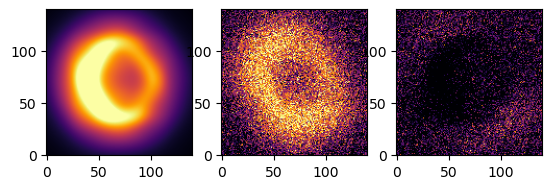

In [16]:
new_disk_params = disk_params.copy()
new_spf_params = spf_params.copy()
new_disk_params['sma'] = soln.x[0]
new_disk_params['inclination'] = soln.x[1]
new_disk_params['position_angle'] = soln.x[2]

fitted_image = objective_model(new_disk_params, new_spf_params, psf_params, Parameter_Index.misc_params, ScatteredLightDisk, DustEllipticalDistribution2PowerLaws,
                                InterpolatedUnivariateSpline_SPF, Winnie_PSF)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(fitted_image, origin='lower', cmap='inferno', vmin=0, vmax=1000)
axes[1].imshow(target_image, origin='lower', cmap='inferno', vmin=0, vmax=1000)
axes[2].imshow(target_image-fitted_image, origin='lower', cmap='inferno', vmin=0, vmax=1000)
plt.show()